In [2]:
%matplotlib inline

import math
import warnings
import numpy as np

# specify to ignore warning messages
warnings.filterwarnings("ignore")

import keras
import sys
sys.path.insert(1,'E:\DUY\DS\deeplearning\PROJECTS\Custom_Tools')
import lstm_tools as lstmt

from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error
np.random.seed(7)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': 14,
          'figure.figsize': (15, 5),
          'axes.labelsize': 14,
          'axes.titlesize':'x-large',
          'xtick.labelsize':12,
          'ytick.labelsize':12}

plt.rcParams.update(params)

In [4]:
train_percent = 0.7
stock_index = '^GSPC'
verbose=True

## Get data

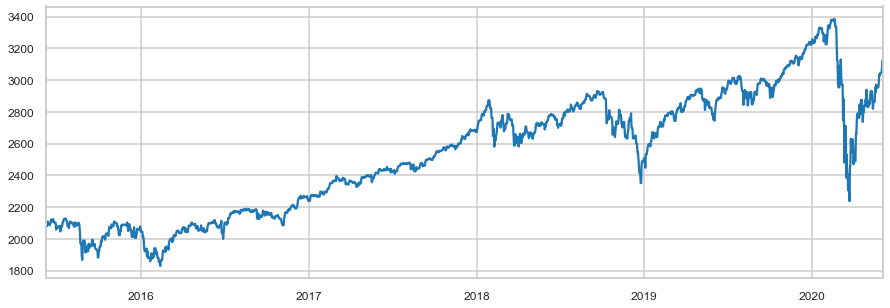

In [5]:
sp_df = lstmt.get_raw_data(stock_index)
sp_close_series = sp_df.Close

sp_close_series.plot()

In [6]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2015-06-08 to 2020-06-05
Freq: D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1825 non-null   float64
 1   Low        1825 non-null   float64
 2   Open       1825 non-null   float64
 3   Close      1825 non-null   float64
 4   Volume     1825 non-null   float64
 5   Adj Close  1825 non-null   float64
dtypes: float64(6)
memory usage: 99.8 KB


## Preprocessing data

In [7]:
# split train and test datasets
train,test,scaler = lstmt.get_seq_train_test(sp_close_series,
                                   scaling=True,
                                   train_size=train_percent)

train = np.reshape(train,(1,train.shape[0],1))
test = np.reshape(test,(1,test.shape[0],1))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))
print("test_x shape={}".format(test_x.shape))

Data Split Complete
train_x shape=(1, 1276, 1)
train_y shape=(1, 1276, 1)
test_x shape=(1, 547, 1)


## Prepare LSTM-Sequence Model

In [8]:
# build RNN model
seq_lstm_model=None
try:
    seq_lstm_model = lstmt.get_seq_model(input_shape=(train_x.shabpe[1],1),verbose=verbose)
except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = lstmt.get_seq_model(input_shape=(train_x.shape[1],1),verbose=verbose)

Model Build Failed. Trying Again
> Compilation Time :  0.03690505027770996
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1276, 4)           96        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1276, 1)           5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


## Fit the Model

In [9]:
seq_lstm_model.fit(train_x, train_y,
               epochs=150, batch_size=1,
               verbose=2)
print("Model Fit Complete")


Epoch 1/150
 - 0s - loss: 0.0608
Epoch 2/150
 - 0s - loss: 0.0528
Epoch 3/150
 - 0s - loss: 0.0478
Epoch 4/150
 - 0s - loss: 0.0439
Epoch 5/150
 - 0s - loss: 0.0408
Epoch 6/150
 - 0s - loss: 0.0382
Epoch 7/150
 - 0s - loss: 0.0359
Epoch 8/150
 - 0s - loss: 0.0339
Epoch 9/150
 - 0s - loss: 0.0321
Epoch 10/150
 - 0s - loss: 0.0305
Epoch 11/150
 - 0s - loss: 0.0290
Epoch 12/150
 - 0s - loss: 0.0277
Epoch 13/150
 - 0s - loss: 0.0265
Epoch 14/150
 - 0s - loss: 0.0253
Epoch 15/150
 - 0s - loss: 0.0243
Epoch 16/150
 - 0s - loss: 0.0234
Epoch 17/150
 - 0s - loss: 0.0225
Epoch 18/150
 - 0s - loss: 0.0216
Epoch 19/150
 - 0s - loss: 0.0209
Epoch 20/150
 - 0s - loss: 0.0202
Epoch 21/150
 - 0s - loss: 0.0195
Epoch 22/150
 - 0s - loss: 0.0188
Epoch 23/150
 - 0s - loss: 0.0182
Epoch 24/150
 - 0s - loss: 0.0177
Epoch 25/150
 - 0s - loss: 0.0171
Epoch 26/150
 - 0s - loss: 0.0166
Epoch 27/150
 - 0s - loss: 0.0161
Epoch 28/150
 - 0s - loss: 0.0157
Epoch 29/150
 - 0s - loss: 0.0152
Epoch 30/150
 - 0s - l

## Train Prediction Performance

In [10]:
trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.02 RMSE


## Test Prediction Performance

In [11]:
# Pad input sequence
testPredict = pad_sequences(test_x,
                                maxlen=train_x.shape[1],
                                padding='post',
                                dtype='float64')
# forecast values
testPredict = seq_lstm_model.predict(testPredict)

# evaluate performances
testScore = math.sqrt(mean_squared_error(test_y[0],
                                         testPredict[0][:test_x.shape[1]]))
print('Test Score: %.2f RMSE' % (testScore))


Test Score: 0.10 RMSE


## Plot Test Prediction

In [12]:
# inverse transformation
trainPredict = scaler.inverse_transform(trainPredict.reshape(trainPredict.shape[1],1))
testPredict = scaler.inverse_transform(testPredict.reshape(testPredict.shape[1],1))

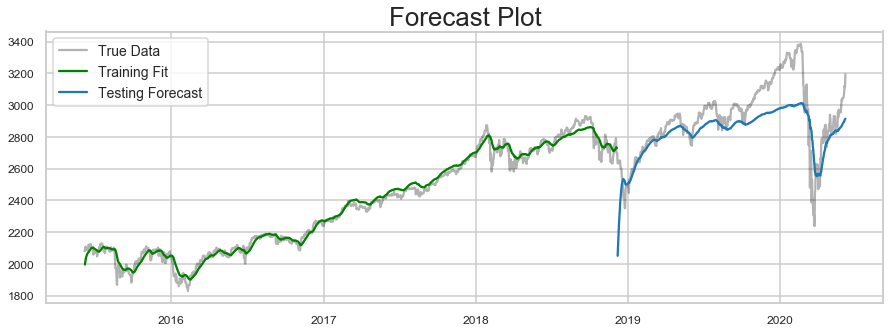

In [13]:
# plot the true and forecasted values
train_size = len(trainPredict)+1

plt.plot(sp_close_series.index,
         sp_close_series.values,c='black',
         alpha=0.3,label='True Data')
plt.plot(sp_close_series.index[1:train_size],
         trainPredict,label='Training Fit',c='g')
plt.plot(sp_close_series.index[train_size+1:],
         testPredict[:test_x.shape[1]],label='Testing Forecast')
plt.title('Forecast Plot')
plt.legend()
plt.show()